#  Catalogs Matching

---
**License**

 Catalogs Matching

 Sat Jul 5 15:00:00 2025\
 Copyright  2025\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Henique Cardoso Naves Lettieri <henrique.cnl23@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---
 catalogs_matching\
 Copyright (C) 2025 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Henrique Cardoso Naves Lettieri <henrique.cnl23@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Libraries & Configs

In [3]:
from numcosmo_py import Nc, Ncm, sky_match
Ncm.cfg_init()

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import pandas as pd

import sys
sys.path.insert(0, "/global/homes/c/cinlima/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/")
from match_id import MatchID as MID

import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")
print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)


GCRCatalogs = 1.9.0 | GCR = 0.9.2


## Data

In [4]:
#Cosmo DC2
cosmodc2= GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

#Cosmo DC2 + RedMaPPer
catalog_dc2_redmapper = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.8.1')

print("CosmoDC2 info:")
print(f"Version: {cosmodc2.get_catalog_info('version')}")
print(f"Sky area: {cosmodc2.get_catalog_info('sky_area')}")
print(f"Cosmology: {cosmodc2.get_catalog_info('cosmology')}")

CosmoDC2 info:
Version: 1.1.4
Sky area: 439.78987
Cosmology: {'H0': 71.0, 'Om0': 0.2648, 'Ob0': 0.0448, 'sigma8': 0.8, 'n_s': 0.963}


Cluster data:

In [5]:
quantities = catalog_dc2_redmapper.list_all_quantities()
cluster_quantities = [q for q in quantities if 'member' not in q]
member_quantities = [q for q in quantities if 'member' in q]
    
cluster_data = Table(catalog_dc2_redmapper.get_quantities(cluster_quantities)) # cDC2 + RM cluster data
member_data = Table(catalog_dc2_redmapper.get_quantities(member_quantities)) # cDC2 + RM member data

Halo data:

In [6]:
# Restrictions on mass and redshift
min_halo_mass = 1e13 #Msun
redshift_max = 1.2

quantities_wanted = ['redshift','halo_mass','halo_id','galaxy_id','ra','dec', 'is_central']
query = GCRCatalogs.GCRQuery('(halo_mass > ' + str(min_halo_mass) +') & (redshift < ' + str(redshift_max) +') & (is_central < ' + str(redshift_max) +') ')
truth_data = Table(cosmodc2.get_quantities(quantities_wanted, [query]))

Selecting halo central members:

In [7]:
table_halos = truth_data[truth_data['is_central'] == True]

## Matchings

### Proximity

NumCosmo's cosmology object:

In [8]:
cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("H0", 71.0)
cosmo.param_set_by_name("Omegab", 0.0448)
cosmo.param_set_by_name("Omegac", 0.2648) #0.2603
cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("w", -1.0) #-1.0

prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA",3.0116707481421923)
prim.param_set_by_name("n_SA", 0.963)

reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

NumCosmo's sky_match object:

In [9]:
halo_coordinates = {"RA":"ra" , "DEC":"dec" , "z":"redshift"}
halo_properties  = {"halo_mass":"mass"}

detections_coordinates =  {"RA":"ra" , "DEC":"dec" , "z":"redshift"}
detections_properties  = {"richness":"R" , "redshift_err":"z_err" , "richness_err":"R_err"}


halos = sky_match.SkyMatch(query_data=table_halos, query_coordinates=halo_coordinates,match_data=cluster_data,
                   match_coordinates=detections_coordinates)

detections = halos.invert_query_match()

Matching:

In [10]:
halos_matched =  halos.match_2d(cosmo, 100 ,distance_method= sky_match.DistanceMethod.QUERY_RADIUS)
detections_matched =  detections.match_2d(cosmo, 100,distance_method= sky_match.DistanceMethod.MATCH_RADIUS)

mask_halos = halos_matched.filter_mask_by_redshift_proximity(sigma_z= 0.0, match_sigma_z_column='redshift_err') & halos_matched.filter_mask_by_distance(1)
mask_detections = detections_matched.filter_mask_by_redshift_proximity(sigma_z= 0.0, query_sigma_z_column='redshift_err') & detections_matched.filter_mask_by_distance(1)

halos_table = halos_matched.to_table_complete(query_properties=halo_properties , match_properties=detections_properties,mask=mask_halos)
detections_table = detections_matched.to_table_complete(query_properties=detections_properties , match_properties=halo_properties,mask=mask_detections)

In [11]:
unique_halos = halos_matched.select_best(mask=mask_halos , selection_criteria=sky_match.SelectionCriteria.DISTANCES)
unique_detections = detections_matched.select_best(mask=mask_detections , selection_criteria=sky_match.SelectionCriteria.MORE_MASSIVE , more_massive_column='halo_mass')

unique_halos_table = halos_matched.to_table_best(best=unique_halos , query_properties=halo_properties , match_properties=detections_properties)
unique_detections_table = detections_matched.to_table_best(best=unique_detections , query_properties=detections_properties , match_properties=halo_properties)

cross_indices = unique_halos.get_cross_match_indices(unique_detections)
cross = Table(names=(unique_halos_table.columns) , dtype=tuple([unique_halos_table.columns[i].dtype for i in range(len(unique_halos_table.columns))]))
for halo in cross_indices:
    cross_halo = unique_halos_table[unique_halos_table['ID'] == halo]
    cross.add_row(cross_halo[0])
    
# cross.write('match_proximity.fits', format='fits')


In [12]:
# cross

### ID

In [13]:
cluster_data['ra'].name = 'cluster_ra'
cluster_data['dec'].name = 'cluster_dec'
cluster_data['redshift'].name = 'cluster_redshift'
cluster_data['redshift_err'].name = 'cluster_redshift_err'

mid = MID(member_data, cluster_data, truth_data)
matchdf = mid.unique_id_match(distance=False)

In [14]:
# matchdf

## Statistics

Number of matched objects:

In [15]:
print("Matched objects :\n")
print(f"Proximity:\t{len(cross['ID'])}")
print(f"ID:\t\t{len(matchdf['id'])}")

Matched objects :

Proximity:	26857
ID:		39600


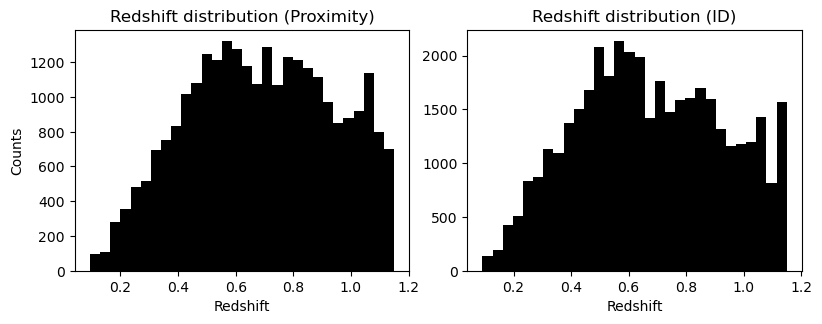

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))
fig.tight_layout() 

axs[0].hist(cross['z_matched'], bins = 30, color= 'k')
axs[0].set_ylabel('Counts')
axs[0].set_xlabel('Redshift')
axs[0].set_title('Redshift distribution (Proximity)')

axs[1].hist(matchdf['cluster_redshift'], bins = 30, color= 'k')
axs[1].set_xlabel('Redshift')
axs[1].set_title('Redshift distribution (ID)')

plt.show()

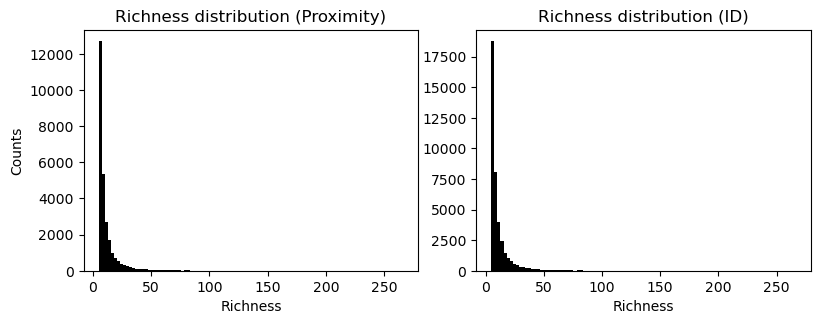

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))
fig.tight_layout() 

axs[0].hist(cross['R'], bins = 100, color= 'k')
axs[0].set_ylabel('Counts')
axs[0].set_xlabel('Richness')
axs[0].set_title('Richness distribution (Proximity)')

axs[1].hist(matchdf['richness'], bins = 100, color= 'k')
axs[1].set_xlabel('Richness')
axs[1].set_title('Richness distribution (ID)')

plt.show()

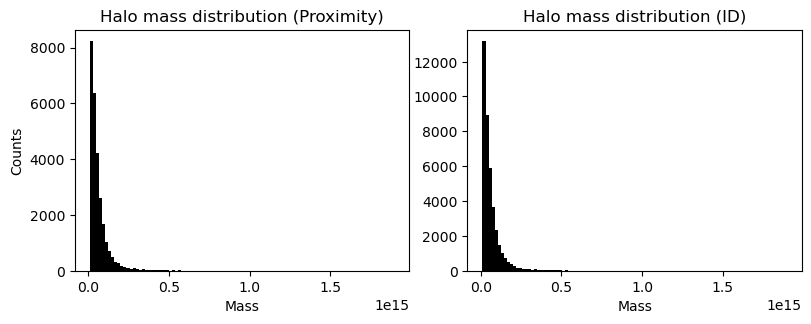

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))
fig.tight_layout() 

axs[0].hist(cross['mass'], bins = 100, color= 'k')
axs[0].set_ylabel('Counts')
axs[0].set_xlabel('Mass')
axs[0].set_title('Halo mass distribution (Proximity)')

axs[1].hist(matchdf['halo_mass'], bins = 100, color= 'k')
axs[1].set_xlabel('Mass')
axs[1].set_title('Halo mass distribution (ID)')

plt.show()

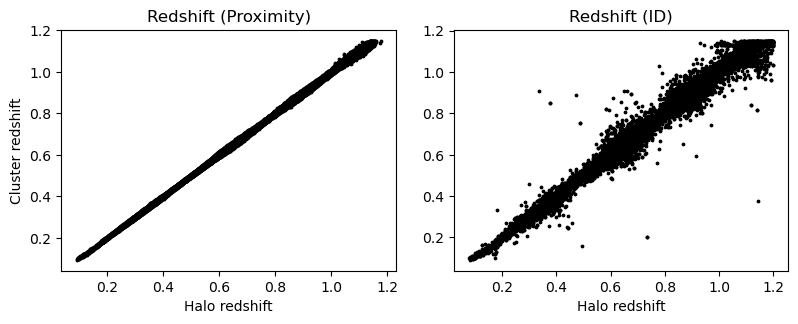

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))
fig.tight_layout() 

axs[0].scatter(cross['z'], cross['z_matched'], c= 'k', s=3)
axs[0].set_ylabel('Cluster redshift')
axs[0].set_xlabel('Halo redshift')
axs[0].set_title('Redshift (Proximity)')

axs[1].scatter(matchdf['redshift'], matchdf['cluster_redshift'], c= 'k', s=3)
axs[1].set_xlabel('Halo redshift')
axs[1].set_title('Redshift (ID)')

plt.show()

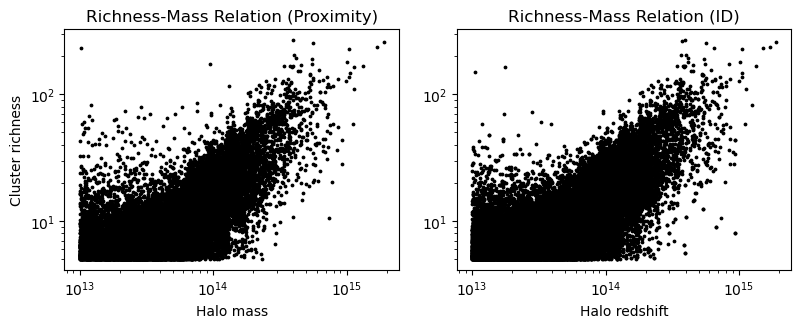

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))
fig.tight_layout() 

axs[0].scatter(cross['mass'], cross['R'], c= 'k', s=3)
axs[0].set_ylabel('Cluster richness')
axs[0].set_xlabel('Halo mass')
axs[0].set_title('Richness-Mass Relation (Proximity)')
axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].scatter(matchdf['halo_mass'], matchdf['richness'], c= 'k', s=3)
axs[1].set_xlabel('Halo redshift')
axs[1].set_title('Richness-Mass Relation (ID)')
axs[1].set_yscale('log')
axs[1].set_xscale('log')

plt.show()